Install python weka and other important libraries

In [0]:
import os
import sys
sys.path
sys.path.append("/usr/lib/jvm/java-11-openjdk-amd64/bin/")
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-11-openjdk-amd64/"
!apt-get install build-essential python3-dev
!apt-get install python3-pil python3-pygraphviz
!apt install openjdk-11-jdk
!pip3 install javabridge --no-cache-dir
!pip3 install python-weka-wrapper3 --no-cache-dir

import weka.core.jvm as jvm
jvm.start(packages=True)

Reading package lists... Done
Building dependency tree       
Reading state information... Done
build-essential is already the newest version (12.4ubuntu1).
python3-dev is already the newest version (3.6.7-1~18.04).
The following package was automatically installed and is no longer required:
  libnvidia-common-430
Use 'apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 7 not upgraded.
Reading package lists... Done
Building dependency tree       
Reading state information... Done
python3-pil is already the newest version (5.1.0-1).
python3-pygraphviz is already the newest version (1.4~rc1-1build2.1).
The following package was automatically installed and is no longer required:
  libnvidia-common-430
Use 'apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 7 not upgraded.
Reading package lists... Done
Building dependency tree       
Reading state information... Done
openjdk-11-jdk is already the newest version (11.0.5+10-0ubuntu1.1~18.04)

Read CSV files from Google Drive. Add the csv files under 
"data/bugs/hadoop.csv"

In [0]:
import os
import pandas as pd
import numpy as np
from google.colab import drive
from weka.core.converters import Loader, TextDirectoryLoader
from weka.classifiers import Classifier, SingleClassifierEnhancer, MultipleClassifiersCombiner, FilteredClassifier, \
    PredictionOutput, Kernel, KernelClassifier
from weka.classifiers import Evaluation
from weka.core.classes import Random
import weka.plot.classifiers as plot_cls
import weka.plot.graph as plot_graph
drive.mount('/content/gdrive')

In [0]:
corpus_name = 'data/bugs/matrixDataNoLabels_cloud_concurrency_bugs.csv'
corpus = os.path.join("/content/gdrive/My Drive", corpus_name)

data_csv = pd.read_csv(corpus)
target_count = data_csv['bug'].value_counts()
print('Bug "False":', target_count[0])
print('Bug "True":', target_count[1])
print('Proportion:', round(target_count[0] / target_count[1], 2), ': 1')

target_count.plot(kind='bar', title='Count (target)');

Dealing with data imbalance

In [0]:
from imblearn.over_sampling import SMOTE

X = data_csv[["loc","wmc","dit","cbo","rfc","lcom"]]
y = data_csv[["bug"]]

smote = SMOTE(random_state=0)
X_resampled, y_resampled = smote.fit_sample(X, y)

X_resampled = pd.DataFrame(X_resampled, columns=X.columns)
y_resampled = pd.DataFrame(y_resampled, columns=y.columns)

sampled = pd.merge_asof(X_resampled,y_resampled,right_index=True,left_index=True)
print(sampled)

#corpus_name = 'data/bugs/resampled.csv'
#corpus = os.path.join("/content/gdrive/My Drive", corpus_name)

#sampled.to_csv(corpus,index = False)

In [0]:
loader = Loader(classname="weka.core.converters.CSVLoader")
data = loader.load_file(corpus)
data.class_is_last()

Naive Bayes Classifier for Bug Prediction

In [0]:
classifier = Classifier(classname="weka.classifiers.bayes.NaiveBayes")
pred_output = PredictionOutput(classname="weka.classifiers.evaluation.output.prediction.PlainText", options=["-distribution"])
evaluation = Evaluation(data)
evaluation.crossvalidate_model(classifier, data, 10, Random(42), output=pred_output)
plot_cls.plot_roc(evaluation, title="ROC bugs",class_index=range(0, data.class_attribute.num_values), wait=False)
plot_cls.plot_prc(evaluation, title="PRC bugs - NaiveBayes",class_index=range(0, data.class_attribute.num_values), wait=False)

Performance Metrics - Naive Bayes Classifier

In [0]:
print(evaluation.summary())
print(evaluation.class_details())
print(evaluation.matrix())

print("confusionMatrix: " + str(evaluation.confusion_matrix))
print("fMeasure: " + str(evaluation.f_measure(1)))
print("precision: " + str(evaluation.precision(1)))
print("recall: " + str(evaluation.recall(1)))

Random Forest Classifier

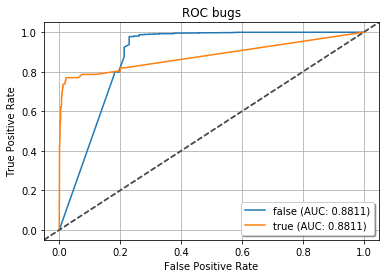

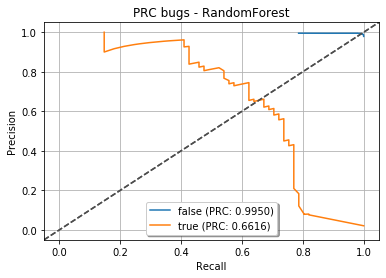

In [0]:
classifier2 = Classifier(classname="weka.classifiers.trees.RandomForest")
evaluation2 = Evaluation(data)
evaluation2.crossvalidate_model(classifier2, data, 10, Random(42))
plot_cls.plot_roc(evaluation2, title="ROC bugs",class_index=range(0, data.class_attribute.num_values), wait=False)
plot_cls.plot_prc(evaluation2, title="PRC bugs - RandomForest",class_index=range(0, data.class_attribute.num_values), wait=False)

Performance Evaluation Metrics - Random Forest

In [0]:
print(evaluation2.summary())
print(evaluation2.class_details())
print(evaluation2.matrix())

print("confusionMatrix: " + str(evaluation2.confusion_matrix))
print("fMeasure: " + str(evaluation2.f_measure(1)))
print("precision: " + str(evaluation2.precision(1)))
print("recall: " + str(evaluation2.recall(1)))


Correctly Classified Instances        2870               98.7612 %
Incorrectly Classified Instances        36                1.2388 %
Kappa statistic                          0.641 
Mean absolute error                      0.0206
Root mean squared error                  0.1032
Relative absolute error                 49.7282 %
Root relative squared error             71.9931 %
Total Number of Instances             2906     

=== Detailed Accuracy By Class ===

                 TP Rate  FP Rate  Precision  Recall   F-Measure  MCC      ROC Area  PRC Area  Class
                 0.997    0.459    0.990      0.997    0.994      0.654    0.881     0.995     false
                 0.541    0.003    0.805      0.541    0.647      0.654    0.881     0.662     true
Weighted Avg.    0.988    0.449    0.986      0.988    0.986      0.654    0.881     0.988     

=== Confusion Matrix ===

    a    b   <-- classified as
 2837    8 |    a = false
   28   33 |    b = true

confusionMatrix: [[2837.    

Logistic Classifier

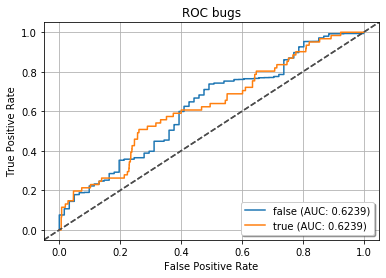

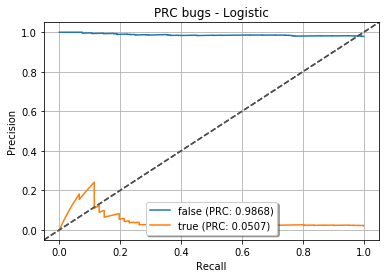

In [0]:
classifier3 = Classifier(classname="weka.classifiers.functions.Logistic")
evaluation3 = Evaluation(data)
evaluation3.crossvalidate_model(classifier3, data, 10, Random(42))
plot_cls.plot_roc(evaluation3, title="ROC bugs",class_index=range(0, data.class_attribute.num_values), wait=False)
plot_cls.plot_prc(evaluation3, title="PRC bugs - Logistic",class_index=range(0, data.class_attribute.num_values), wait=False)

Pervormance Evaluation Metrics - Logistic

In [0]:
print(evaluation3.summary())
print(evaluation3.class_details())
print(evaluation3.matrix())

print("confusionMatrix: " + str(evaluation3.confusion_matrix))
print("fMeasure: " + str(evaluation3.f_measure(1)))
print("precision: " + str(evaluation3.precision(1)))
print("recall: " + str(evaluation3.recall(1)))


Correctly Classified Instances        3464               60.8787 %
Incorrectly Classified Instances      2226               39.1213 %
Kappa statistic                          0.2176
Mean absolute error                      0.4593
Root mean squared error                  0.4794
Relative absolute error                 91.8666 %
Root relative squared error             95.8739 %
Total Number of Instances             5690     

=== Detailed Accuracy By Class ===

                 TP Rate  FP Rate  Precision  Recall   F-Measure  MCC      ROC Area  PRC Area  Class
                 0.742    0.524    0.586      0.742    0.655      0.226    0.663     0.705     False
                 0.476    0.258    0.648      0.476    0.549      0.226    0.663     0.652     True
Weighted Avg.    0.609    0.391    0.617      0.609    0.602      0.226    0.663     0.679     

=== Confusion Matrix ===

    a    b   <-- classified as
 2111  734 |    a = False
 1492 1353 |    b = True

confusionMatrix: [[2111.  73